<a href="https://www.kaggle.com/jarupula/mh-wipro-sustainability-ml-challenge?scriptVersionId=88615509" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing libraries📚

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Reading data📋

In [2]:
train = pd.read_csv('../input/machinehack-wipro-sustainabilitychallenge/train.csv',
                   parse_dates={'datetime': [0,1,2,3,4]}, 
                   date_parser=lambda *columns: datetime.datetime(*map(int, columns)),
                   keep_date_col=True)
convert_dict = {'Year': int,'Month': int,'Day': int,'Hour': int, 'Minute': int}
train = train.set_index('datetime')
train = train.astype(convert_dict)

test = pd.read_csv('../input/machinehack-wipro-sustainabilitychallenge/test.csv',
                   parse_dates={'datetime': [0,1,2,3,4]}, 
                   date_parser=lambda *columns: datetime.datetime(*map(int, columns)),
                  keep_date_col=True)
test = test.set_index('datetime')
test = test.astype(convert_dict)

sample_sub = pd.read_csv('../input/machinehack-wipro-sustainabilitychallenge/sample_submission.csv')

In [3]:
print(f'\nTrain shape: {train.shape}, \nTest shape: {test.shape}, \nSample shape: {sample_sub.shape}')


Train shape: (175296, 18), 
Test shape: (17520, 18), 
Sample shape: (17520, 3)


In [4]:
train.head()

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
datetime,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,0,0,0,0,0,0.0,5.0,1010,75.34,106.15,0.499,346.1,3.1,0
2009-01-01 00:30:00,2009,1,1,0,30,0,0,0,0,1.0,5.0,1010,80.81,112.28,0.490,346.1,3.1,0
2009-01-01 01:00:00,2009,1,1,1,0,0,0,0,4,0.0,5.0,1010,78.27,118.50,0.482,347.9,3.2,0
2009-01-01 01:30:00,2009,1,1,1,30,0,0,0,4,0.0,4.0,1010,78.27,124.78,0.478,347.9,3.1,0
2009-01-01 02:00:00,2009,1,1,2,0,0,0,0,4,0.0,4.0,1010,76.45,131.12,0.475,350.0,3.0,0


#### Missing values counts

In [5]:
train.isna().sum()

Year                  0
Month                 0
Day                   0
Hour                  0
Minute                0
Clearsky DHI          0
Clearsky DNI          0
Clearsky GHI          0
Cloud Type            0
Dew Point             0
Temperature           0
Pressure              0
Relative Humidity     0
Solar Zenith Angle    0
Precipitable Water    0
Wind Direction        0
Wind Speed            0
Fill Flag             0
dtype: int64

In [6]:
test.isna().sum()

Year                      0
Month                     0
Day                       0
Hour                      0
Minute                    0
Cloud Type                0
Dew Point                 0
Temperature               0
Pressure                  0
Relative Humidity         0
Solar Zenith Angle        0
Precipitable Water        0
Wind Direction            0
Wind Speed                0
Fill Flag                 0
Clearsky DHI          17520
Clearsky DNI          17520
Clearsky GHI          17520
dtype: int64

✔NO MISSING DATA

In [7]:
train.describe()

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
count,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000
mean,2013.500274,6.523549,15.727820,11.500000,15.000000,53.065426,330.065295,254.365490,2.540474,13.564431,18.266769,1003.185230,79.376366,89.729463,2.903732,188.877796,2.262871,0.740433
std,2.871908,3.448543,8.799349,6.922206,15.000043,64.201407,370.030821,327.705006,3.021879,8.196787,8.943096,5.935749,19.678235,40.085451,1.546979,99.014733,1.281902,6.575655
min,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,-9.000000,970.000000,7.190000,8.550000,0.122000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,12.000000,1000.000000,65.590000,56.450000,1.534000,97.400000,1.300000,0.000000
50%,2013.500000,7.000000,16.000000,11.500000,15.000000,0.000000,0.000000,0.000000,1.000000,15.000000,20.000000,1000.000000,84.230000,89.860000,2.866000,200.000000,2.000000,0.000000
75%,2016.000000,10.000000,23.000000,17.250000,30.000000,103.000000,736.000000,535.000000,6.000000,21.000000,25.000000,1010.000000,97.950000,123.060000,4.223000,272.000000,3.000000,0.000000
max,2018.000000,12.000000,31.000000,23.000000,30.000000,565.000000,1040.000000,1063.000000,10.000000,26.900000,40.000000,1024.000000,100.000000,171.550000,7.700000,360.000000,12.900000,100.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175296 entries, 2009-01-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                175296 non-null  int64  
 1   Month               175296 non-null  int64  
 2   Day                 175296 non-null  int64  
 3   Hour                175296 non-null  int64  
 4   Minute              175296 non-null  int64  
 5   Clearsky DHI        175296 non-null  int64  
 6   Clearsky DNI        175296 non-null  int64  
 7   Clearsky GHI        175296 non-null  int64  
 8   Cloud Type          175296 non-null  int64  
 9   Dew Point           175296 non-null  float64
 10  Temperature         175296 non-null  float64
 11  Pressure            175296 non-null  int64  
 12  Relative Humidity   175296 non-null  float64
 13  Solar Zenith Angle  175296 non-null  float64
 14  Precipitable Water  175296 non-null  float64
 15  

# EDA📈

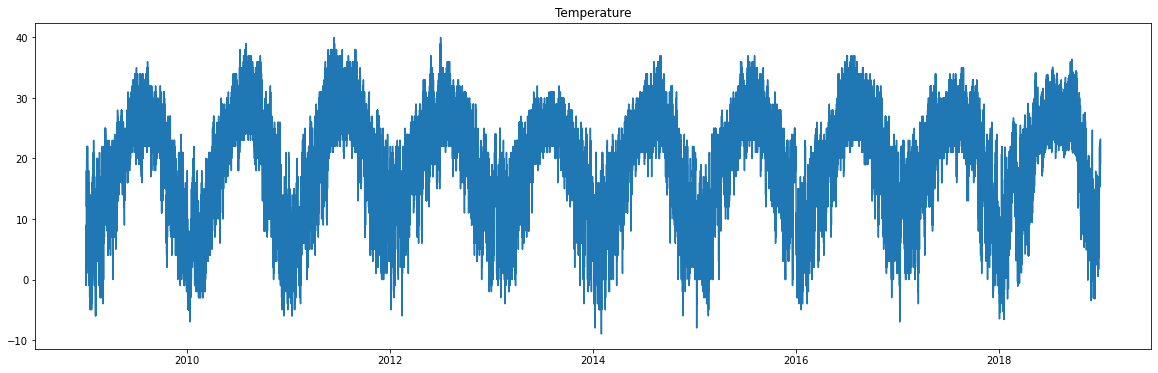

In [9]:
plt.figure(figsize=(20, 6))
plt.plot(train['Temperature'])
plt.title('Temperature')
plt.show()

✔ As expected there is a cyclic pattern

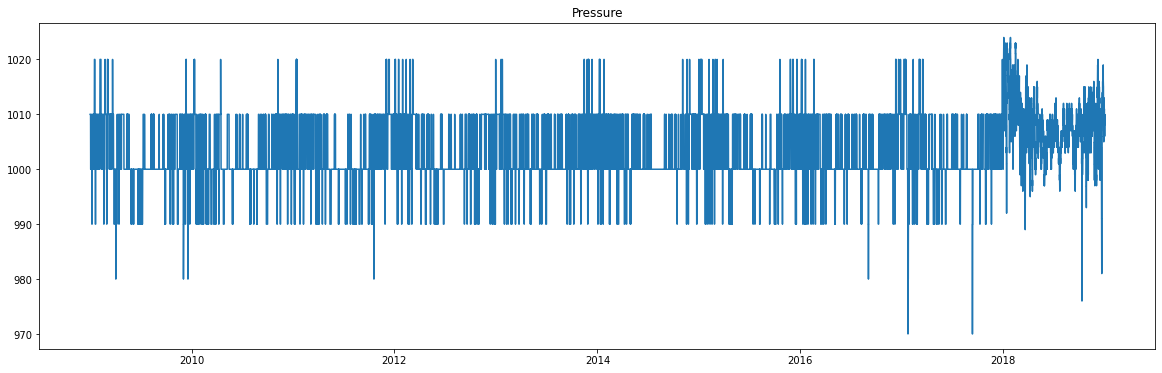

In [10]:
plt.figure(figsize=(20, 6))
plt.plot(train['Pressure'])
plt.title('Pressure')
plt.show()

✔ It seems that the organization installed more accurate pressure(analog) measurement device in 2018

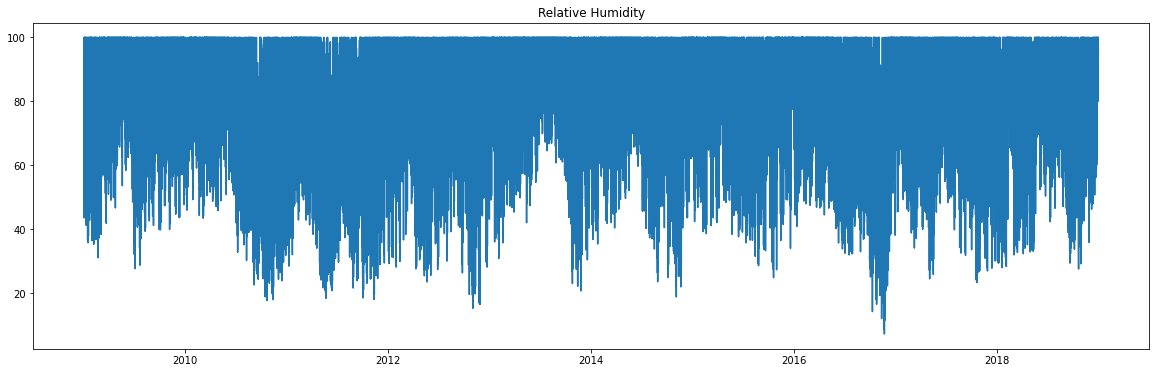

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(train['Relative Humidity'])
plt.title('Relative Humidity')
plt.show()

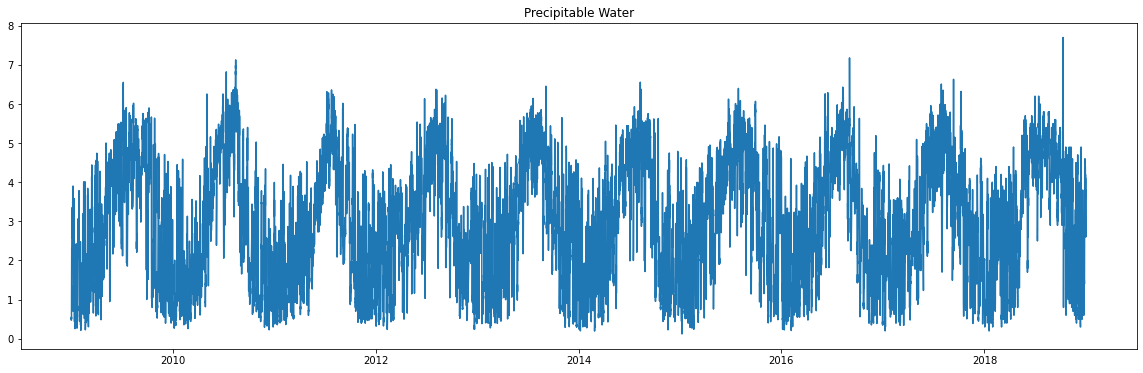

In [12]:
plt.figure(figsize=(20, 6))
plt.plot(train['Precipitable Water'])
plt.title('Precipitable Water')
plt.show()

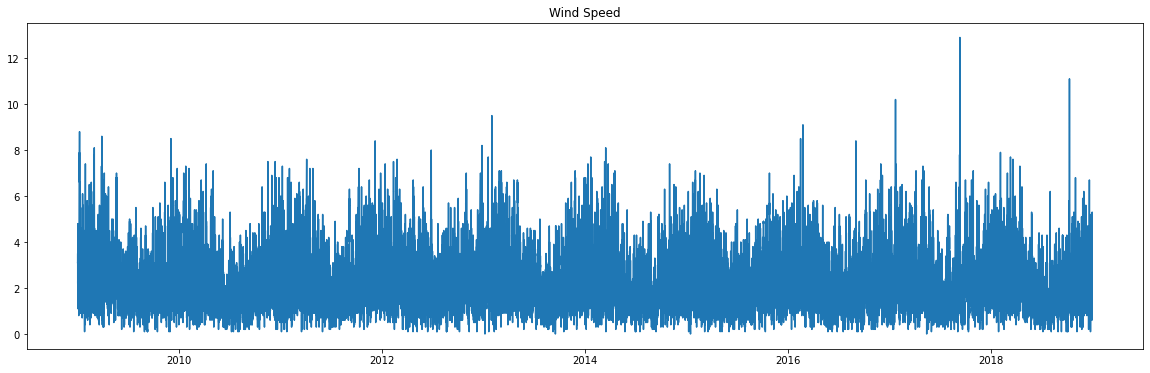

In [13]:
plt.figure(figsize=(20, 6))
plt.plot(train['Wind Speed'])
plt.title('Wind Speed')
plt.show()

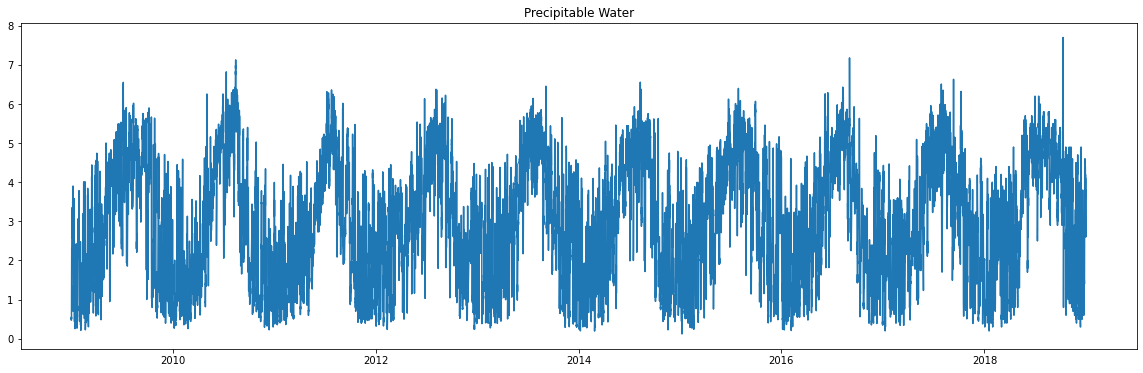

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(train['Precipitable Water'])
plt.title('Precipitable Water')
plt.show()

✔Wind speed also has seasonality

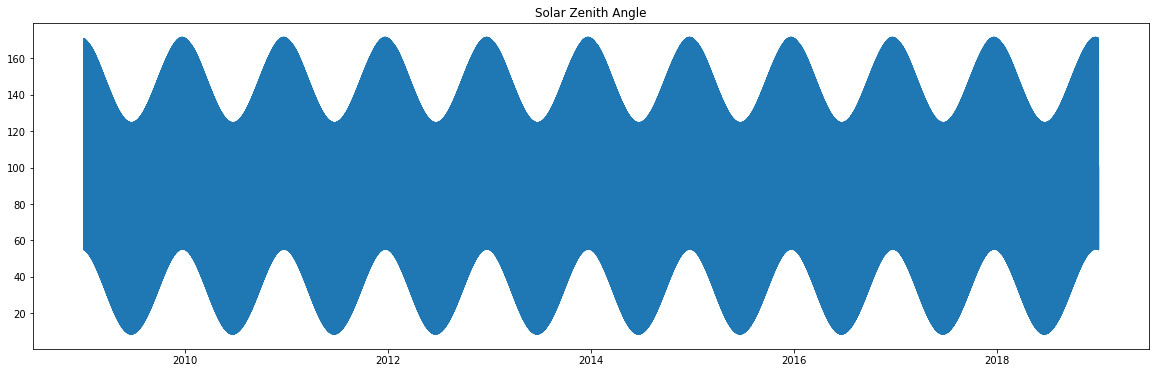

In [15]:
plt.figure(figsize=(20, 6))
plt.plot(train['Solar Zenith Angle'])
plt.title('Solar Zenith Angle')
plt.show()

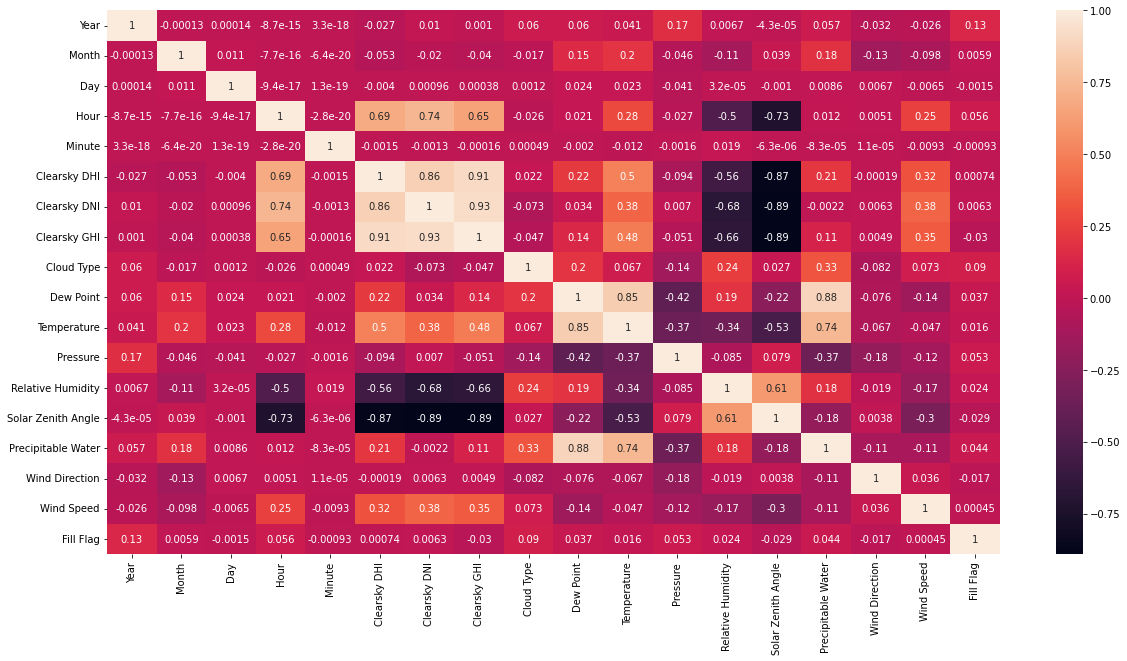

In [16]:
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(), annot=True)
plt.show()

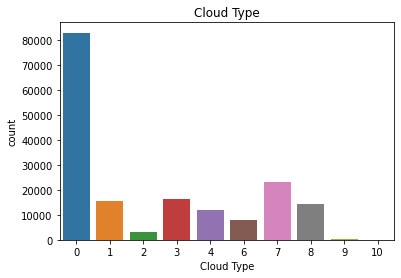

In [17]:
sns.countplot(train['Cloud Type'])
plt.title('Cloud Type')
plt.show()

✔Most of the time sky is clear

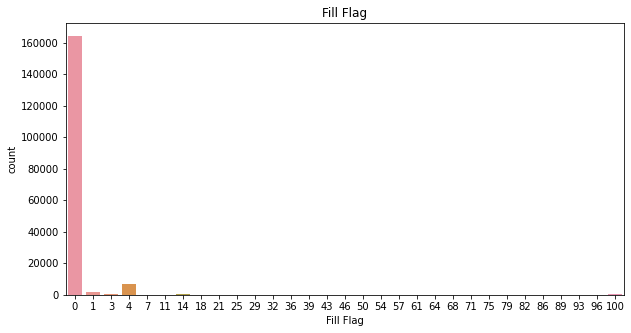

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(train['Fill Flag'])
plt.title('Fill Flag')
plt.show()

### Targets

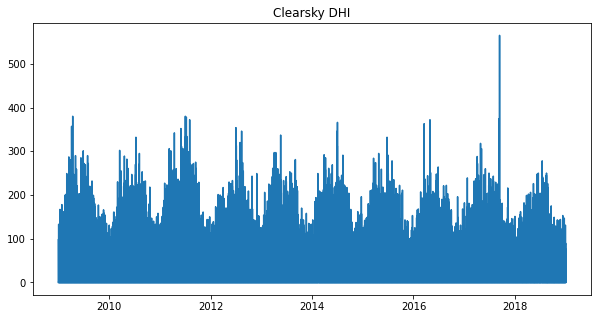

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train['Clearsky DHI'])
plt.title('Clearsky DHI')
plt.show()

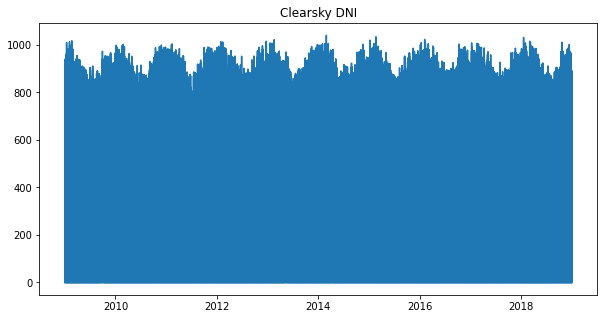

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(train['Clearsky DNI'])
plt.title('Clearsky DNI')
plt.show()

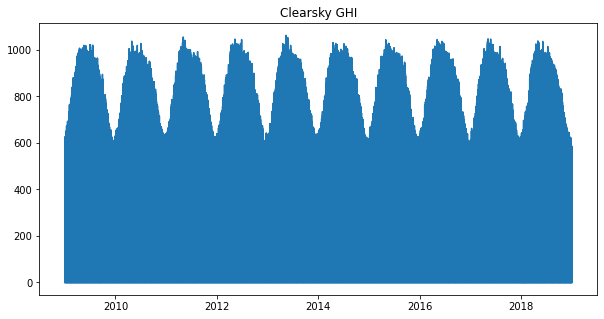

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(train['Clearsky GHI'])
plt.title('Clearsky GHI')
plt.show()

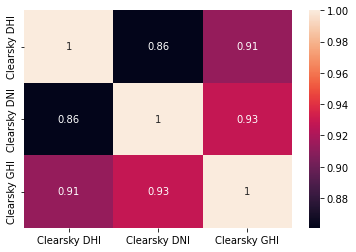

In [22]:
sns.heatmap(train[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']].corr(), annot=True)
plt.show()

✔Target columns are correlated, so making individual model is not a good idea.

# Pre-Processing and FE🛠

In [23]:
def map_pressure(pressure):
    if pressure < 975:
        return 970
    elif 975 <= pressure < 985:
        return 980
    elif 985 <= pressure < 995:
        return 990
    elif 995 <= pressure < 1005:
        return 1000
    elif 1005 <= pressure < 1015:
        return 1010
    else:
        return 1020

In [24]:
def get_time_of_the_days(x):
    if x < 6:
        return 'Early morning'
    elif x < 12:
        return 'Morning'
    elif x < 16:
        return 'Afternoon'
    elif x < 19:
        return 'Evening'
    else:
        return 'Night'

In [25]:
def get_season(x):
    if x < 3:
        return 'Winter'
    elif x < 6:
        return 'Spring'
    elif x < 9:
        return 'Summer'
    elif x < 12:
        return 'Automn'
    else:
        return 'Winter'

In [26]:
def pre_process(df):
    df['Pressure'] = df['Pressure'].apply(map_pressure)
    df['P/P0'] = df['Pressure'] / 1013.25
    df['TOD'] = df['Hour'].apply(get_time_of_the_days)
    df['season'] = df['Month'].apply(get_season)
    
    return df

In [27]:
def add_general_feat(df):
    num = 1.002432*(np.cos(np.radians(df['Solar Zenith Angle'])))**2+ 0.148386*(np.cos(np.radians(df['Solar Zenith Angle'])))+0.0096467
    den = (np.cos(np.radians(df['Solar Zenith Angle'])))**3+ 0.149864*(np.cos(np.radians(df['Solar Zenith Angle'])))**2+0.0102963*(np.cos(np.radians(df['Solar Zenith Angle']))) + 0.000303978
    df['AM'] = num / den
    df['del_cda'] = 1/(9.4+0.9*df['AM'])
    
    return df

In [28]:
def add_date_feat(df):
    df = df.reset_index()
    df['day_of_year'] = df['datetime'].apply(lambda x: int(x.strftime('%j')))
    df['week_of_year'] = df['datetime'].apply(lambda x: int(x.strftime('%U')))
    df = df.set_index('datetime')
    return df

In [29]:
def main(df):
    df = add_date_feat(df)
    df = pre_process(df)
    df = add_general_feat(df)
    
    return df

In [30]:
train = main(train)
test = main(test)


# Training🏋️‍♂️

In [31]:
X = train.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1)
y = train[['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI']]

In [32]:
cat_col = ['Cloud Type', 'TOD', 'season']
num_col = [col for col in X.columns if col not in cat_col]

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=3)

X_test = test.drop(['Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI'], axis=1)

In [34]:
transform = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), cat_col),
    ('pass', 'passthrough', num_col)
])

In [35]:
X_train = transform.fit_transform(X_train)
X_val = transform.transform(X_val)

X_test = transform.transform(X_test)

In [36]:
model = keras.models.Sequential([
    keras.layers.Dense(800, input_dim=(len(X_train[0])), activation='relu',
                       kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),),
    keras.layers.Dense(400, activation='relu',
                       kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),),
    keras.layers.Dense(200, activation='relu', 
                       kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-3),),
    keras.layers.Dense(180, activation='relu', 
                       kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),),
   
    keras.layers.Dense(y_train.shape[1])
])

model.compile(loss='mean_squared_error', optimizer='adam')

2022-02-24 05:23:02.876296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 05:23:02.985448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 05:23:02.986532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 05:23:02.987968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [37]:
chkpoint_cb = keras.callbacks.ModelCheckpoint("model_submission.h5",save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25,restore_best_weights=True)
lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10,mode='min',min_lr=0)

In [38]:
EPOCHS = 150
BATCH_SIZE = 256

In [39]:
history = model.fit(X_train, y_train, epochs=EPOCHS,batch_size=BATCH_SIZE, 
                    validation_data = (X_val, y_val),
                    callbacks = [chkpoint_cb, early_stopping_cb, lr_reduce])

2022-02-24 05:23:05.754891: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
480/480 [==============================] - 3s 4ms/step - loss: 9132.8359 - val_loss: 1671.7817
Epoch 2/150
480/480 [==============================] - 2s 3ms/step - loss: 1086.0953 - val_loss: 854.9573
Epoch 3/150
480/480 [==============================] - 2s 3ms/step - loss: 961.9820 - val_loss: 793.6337
Epoch 4/150
480/480 [==============================] - 2s 4ms/step - loss: 962.7599 - val_loss: 1405.9331
Epoch 5/150
480/480 [==============================] - 2s 3ms/step - loss: 850.3833 - val_loss: 827.5311
Epoch 6/150
480/480 [==============================] - 2s 3ms/step - loss: 869.7207 - val_loss: 1794.1138
Epoch 7/150
480/480 [==============================] - 2s 3ms/step - loss: 838.1978 - val_loss: 1038.9819
Epoch 8/150
480/480 [==============================] - 2s 3ms/step - loss: 787.9749 - val_loss: 746.8174
Epoch 9/150
480/480 [==============================] - 2s 3ms/step - loss: 770.0484 - val_loss: 707.4601
Epoch 10/150
480/480 [===========================

### Train predictions

In [40]:
y_train_pred = pd.DataFrame(model.predict(X_train), columns = sample_sub.columns)

In [41]:
print('Scores...Train\n')
print(f'{y_train.iloc[:, 0].name}: {mean_squared_error(y_train.iloc[:, 0].values,y_train_pred.iloc[:, 0].values)}')
print(f'{y_train.iloc[:, 1].name}: {mean_squared_error(y_train.iloc[:, 1].values,y_train_pred.iloc[:, 1].values)}')
print(f'{y_train.iloc[:, 2].name}: {mean_squared_error(y_train.iloc[:, 2].values,y_train_pred.iloc[:, 2].values)}')

Scores...Train

Clearsky DHI: 189.33006778683182
Clearsky DNI: 1045.1026672634878
Clearsky GHI: 32.000780308178136


### Val predictions

In [42]:
y_val_pred = pd.DataFrame(model.predict(X_val), columns = sample_sub.columns)

In [43]:
print('Scores...Validation\n')
print(f'{y_val.iloc[:, 0].name}: {mean_squared_error(y_val.iloc[:, 0].values,y_val_pred.iloc[:, 0].values)}')
print(f'{y_val.iloc[:, 1].name}: {mean_squared_error(y_val.iloc[:, 1].values,y_val_pred.iloc[:, 1].values)}')
print(f'{y_val.iloc[:, 2].name}: {mean_squared_error(y_val.iloc[:, 2].values,y_val_pred.iloc[:, 2].values)}')

Scores...Validation

Clearsky DHI: 206.77747999062447
Clearsky DNI: 1151.0650328339234
Clearsky GHI: 34.62328291805483


### loss

In [44]:
hist_df = pd.DataFrame(history.history)

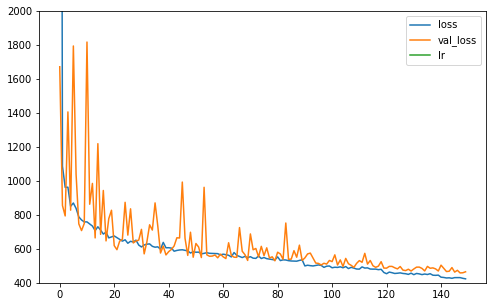

In [45]:
hist_df.plot(figsize=(8,5))
plt.gca().set_ylim(400,2000)
plt.show()

# Inference🛰

In [46]:
sample_sub = pd.DataFrame(model.predict(X_test), columns=sample_sub.columns)
sample_sub[sample_sub < 0] = 0

In [47]:
sample_sub

,Clearsky DHI,Clearsky DNI,Clearsky GHI
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.037387,0.000000
4,0.000000,0.026381,0.000000
...,...,...,...
17515,48.487247,657.642273,186.258606
17516,36.435699,501.271393,94.951355
17517,13.699903,198.472519,22.699909
17518,0.338092,0.360919,0.130432


In [48]:
sample_sub.to_csv('submission.csv', index=None)